⚔️ PREPARANDO PARA A BATALHA...
Dados crus carregados: (22544, 42)
Dados alinhados com o treino: (22544, 123)

🧠 Carregando a IA...

🏆 ACURÁCIA NO BOSS FINAL: 76.89%

📋 Relatório:
              precision    recall  f1-score   support

      Normal       0.66      0.97      0.78      9711
      Ataque       0.97      0.61      0.75     12833

    accuracy                           0.77     22544
   macro avg       0.81      0.79      0.77     22544
weighted avg       0.83      0.77      0.77     22544



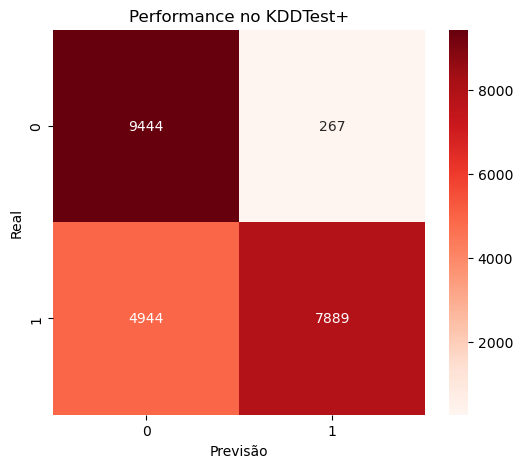

In [ ]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. CONFIGURAÇÃO DE CAMINHOS ---
# O arquivo "Boss Final" (Teste cru)
caminho_teste_cru = r"E:\Estudos_Cybersecurity\Datasets_Cybersecurity\NSL-KDD\nsl-kdd\KDDTest+.txt"
# O gabarito (vamos ler só o cabeçalho do arquivo que criamos antes)
caminho_treino_ready = r"E:\Estudos_Cybersecurity\Datasets_Cybersecurity\train_ready.csv"
# O cérebro da IA
caminho_modelo = r"E:\Estudos_Cybersecurity\Modelos\modelo_random_forest_v1.pkl"

colunas = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class', 'difficulty_level'
]

print("⚔️ PREPARANDO PARA A BATALHA...")

# --- 2. CARREGAMENTO E LIMPEZA BÁSICA ---
df_test = pd.read_csv(caminho_teste_cru, names=colunas, index_col=False)
df_test = df_test.drop('difficulty_level', axis=1)
df_test['target'] = df_test['class'].apply(lambda x: 0 if x == 'normal' else 1)
df_test = df_test.drop('class', axis=1)

print(f"Dados crus carregados: {df_test.shape}")

# --- 3. ONE-HOT ENCODING (Vai gerar colunas diferentes do treino) ---
cols_categoricas = ['protocol_type', 'service', 'flag']
df_test = pd.get_dummies(df_test, columns=cols_categoricas)

# --- 4. O PULO DO GATO: ALINHAMENTO DE COLUNAS ---
# Carrega apenas o cabeçalho do treino para saber a ordem correta
df_treino_template = pd.read_csv(caminho_treino_ready, nrows=0)
colunas_esperadas = df_treino_template.columns.drop('target') # O modelo não usa a coluna 'target' para prever

# Passo A: Adicionar colunas que faltam no teste (preenchendo com 0)
for col in colunas_esperadas:
    if col not in df_test.columns:
        df_test[col] = 0

# Passo B: Remover colunas extras que tem no teste mas não tinha no treino
# (Ex: um serviço novo que a IA nunca viu e não sabe o que fazer)
df_test = df_test[colunas_esperadas.tolist() + ['target']]

print(f"Dados alinhados com o treino: {df_test.shape}")

# --- 5. NORMALIZAÇÃO ---
# (Nota: Em produção real, usaríamos o mesmo 'scaler' salvo do treino. Aqui vamos ajustar um novo para simplificar)
scaler = MinMaxScaler()
cols_to_scale = df_test.columns.drop('target')
df_test[cols_to_scale] = scaler.fit_transform(df_test[cols_to_scale])

# --- 6. HORA DA VERDADE: PREVISÃO ---
print("\n🧠 Carregando a IA...")
modelo = joblib.load(caminho_modelo)

X_test_final = df_test.drop('target', axis=1)
y_test_final = df_test['target']

previsoes = modelo.predict(X_test_final)
acuracia = accuracy_score(y_test_final, previsoes) * 100

print(f"\n🏆 ACURÁCIA NO BOSS FINAL: {acuracia:.2f}%")

# --- 7. ANÁLISE DE ERROS ---
print("\n📋 Relatório:")
print(classification_report(y_test_final, previsoes, target_names=['Normal', 'Ataque']))

cm = confusion_matrix(y_test_final, previsoes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Performance no KDDTest+')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()